In [7]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
from selection import load_data,save,generate_labels

In [3]:
name = 'AAPL_2Y60min'
path = '/Users/abhijitdeshpande/Downloads/DJI65_2Y60min/'

In [17]:
data = load_data(name)

In [18]:
labels = generate_labels(data)

In [6]:
data.drop('time',axis=1, inplace=True)

In [6]:
def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0

In [7]:
def get_atr(stock, win=14):
    
    atr_df = pd.Series(index=stock.index)
    high = pd.Series(adj.high.rolling( \
                     win, min_periods=win))
    low = pd.Series(adj.low.rolling( \
                    win, min_periods=win))
    close = pd.Series(adj.close.rolling( \
                      win, min_periods=win))    
          
    for i in range(len(stock.index)):
        tr=np.max([(high[i] - low[i]), \
                  np.abs(high[i] - close[i]), \
                  np.abs(low[i] - close[i])], \
                  axis=0)
        atr_df[i] = tr.sum() / win
     
    return  atr_df

In [8]:
def get_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 
              'price', 'vert_barrier', \
              'top_barrier', 'bottom_barrier'], \
               index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc \
                      [daily_volatility.index[0] : day])
        #set the vertical barrier 
        if ((days_passed + t_final) < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price', 
            'vert_barrier','top_barrier', 'bottom_barrier']] = \
             days_passed, prices.loc[day], vert_barrier, \
             top_barrier, bottom_barrier
    return barriers

In [9]:
#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(data.close)
# how many days we hold the stock which set the vertical barrier
t_final = 30
#the up and low boundary multipliers
upper_lower_multipliers = [4, 1]
#allign the index
prices = data.close[daily_volatility.index]

In [10]:
#daily_volatility.loc[daily_volatility.index[850]:daily_volatility.index[]].std()+2

In [11]:
barriers = get_barriers()

In [14]:
barriers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7880 entries, 2018-09-28 07:00:00 to 2020-09-16 20:00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   days_passed     7880 non-null   object
 1   price           7880 non-null   object
 2   vert_barrier    7849 non-null   object
 3   top_barrier     7880 non-null   object
 4   bottom_barrier  7880 non-null   object
 5   out             0 non-null      object
dtypes: object(6)
memory usage: 689.0+ KB


In [13]:
barriers['out'] = None
barriers[15:25]

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
time,,,,,,
2018-10-01 06:00:00,16,227.6,2018-10-03 07:00:00,229.968359,227.00791,None
2018-10-01 07:00:00,17,227.98,2018-10-03 08:00:00,230.216038,227.42099,None
2018-10-01 08:00:00,18,227.85,2018-10-03 09:00:00,230.016991,227.308252,None
2018-10-01 09:00:00,19,227.77,2018-10-03 10:00:00,229.849037,227.250241,None
2018-10-01 10:00:00,20,228.79,2018-10-03 11:00:00,231.032394,228.229402,None
2018-10-01 11:00:00,21,228.87,2018-10-03 12:00:00,231.003647,228.336588,None
2018-10-01 12:00:00,22,228.88,2018-10-03 13:00:00,230.921183,228.369704,None
2018-10-01 13:00:00,23,227.5775,2018-10-03 14:00:00,230.299111,226.897097,None
2018-10-01 14:00:00,24,227.74,2018-10-03 15:00:00,230.319489,227.095128,None


In [15]:
def get_labels():
 
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]
            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]
            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
             top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
             bottom_barrier).any()
            #assign the labels
            if condition_pt: 
                barriers['out'][i] = 1
            elif condition_sl: 
                barriers['out'][i] = -1    
            else: 
                barriers['out'][i] = max(
                          [(price_final - price_initial)/ 
                           (top_barrier - price_initial), \
                           (price_final - price_initial)/ \
                           (price_initial - bottom_barrier)],\
                            key=abs)
                #barriers['out'][i] = 0
    return 
get_labels()

In [16]:
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
time,,,,,,
2018-09-28 07:00:00,1,224.0,2018-10-02 08:00:00,226.622563,223.344359,1
2018-09-28 08:00:00,2,223.92,2018-10-02 09:00:00,225.786071,223.453482,1
2018-09-28 09:00:00,3,224.7,2018-10-02 10:00:00,227.25238,224.061905,1
2018-09-28 10:00:00,4,224.74,2018-10-02 11:00:00,226.894404,224.201399,1
2018-09-28 11:00:00,5,225.5703,2018-10-02 12:00:00,227.897485,224.988504,1
...,...,...,...,...,...,...
2020-09-16 16:00:00,7876,112.13,NaN,114.554102,111.523974,None
2020-09-16 17:00:00,7877,112.54,NaN,114.989288,111.927678,None
2020-09-16 18:00:00,7878,112.7,NaN,115.071154,112.107212,None


In [17]:
barriers['vert_barrier'] = barriers['vert_barrier'].map(lambda x:x)
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
time,,,,,,
2018-09-28 07:00:00,1,224.0,2018-10-02 08:00:00,226.622563,223.344359,1
2018-09-28 08:00:00,2,223.92,2018-10-02 09:00:00,225.786071,223.453482,1
2018-09-28 09:00:00,3,224.7,2018-10-02 10:00:00,227.25238,224.061905,1
2018-09-28 10:00:00,4,224.74,2018-10-02 11:00:00,226.894404,224.201399,1
2018-09-28 11:00:00,5,225.5703,2018-10-02 12:00:00,227.897485,224.988504,1
...,...,...,...,...,...,...
2020-09-16 16:00:00,7876,112.13,NaN,114.554102,111.523974,None
2020-09-16 17:00:00,7877,112.54,NaN,114.989288,111.927678,None
2020-09-16 18:00:00,7878,112.7,NaN,115.071154,112.107212,None


In [18]:
barriers.out.value_counts()

-1.000000    3730
 1.000000    3610
 2.361610       1
 2.785198       1
-0.363894       1
             ... 
 1.816818       1
 1.226015       1
 1.772707       1
 0.981088       1
 0.568193       1
Name: out, Length: 511, dtype: int64

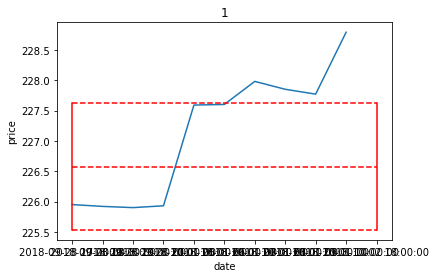

In [371]:
fig,ax = plt.subplots()
ax.set(title=barriers.out.iloc[10],
       xlabel='date', ylabel='price')
ax.plot(barriers.price[10: 20])
start = barriers.index[10]
end = barriers.vert_barrier[10]
upper_barrier = barriers.top_barrier[10]
lower_barrier = barriers.bottom_barrier[10]
ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

In [372]:
def getWeights(d,size):
    # thres>0 drops insignificant weights
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w 

#getWeights(0.1, s_.shape[0])

In [373]:
#getWeights(0.1, barriers.price.shape[0])

In [374]:
 def fracDiff(series, d, thres=0.01):
    '''
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily
        bounded between [0,1]
    '''
    #1) Compute weights for the longest series
    w=getWeights(d, series.shape[0])
    #bp()
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc=seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc]=np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [377]:
f_d = fracDiff(data[['close']], 0.5)

In [378]:
barriers.price.shape, f_d.shape

((7880,), (7420, 1))

In [380]:
#dropped_date = data.drop('date',axis=1)

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
scale = StandardScaler()
scaled_data = scale.fit_transform(dropped_date)

In [106]:
scale_data = pd.DataFrame(scaled_data,columns=dropped_date.columns)

In [107]:
scale_data.index = data.index

In [381]:
labels = barriers.dropna()[['out']].applymap(lambda x: int(1) if x>=0.5 else int(0))

In [383]:
final_data = pd.concat([scale_data,labels],axis=1).dropna()
#final_data.out = final_data.out.astype('int64')

NameError: name 'scale_data' is not defined

In [111]:
final_data.out.value_counts()

0    165
1    138
Name: out, dtype: int64

In [32]:
final_data.to_csv('/Users/abhijitdeshpande/Documents/Project Files/Data Files/'+name+'.csv',index=False)

In [33]:
final_data.shape

(303, 70)

In [16]:
import talib as ta
from talib import abstract

In [17]:
t = ['MA','BBANDS','CMO','RSI', 'MACD','AROONOSC','ADX','CCI']

In [18]:
df = data.copy()

In [19]:
df['MA'] = abstract.MA(data)

In [20]:
df['CMO'] = abstract.CMO(data)

In [21]:
df['RSI'] = abstract.RSI(data)
df['AROONOSC'] = abstract.AROONOSC(data)
df['ADX'] = abstract.ADX(data)
df['CCI'] = abstract.CCI(data)

In [22]:
df[['upperband', 'middleband', 'lowerband']] = abstract.BBANDS(data)

In [23]:
df[['macd', 'macdsignal', 'macdhist']] = abstract.MACD(data)

In [24]:
df.dropna(inplace=True)

In [25]:
final_data = pd.concat([df,labels],axis=1)

NameError: name 'labels' is not defined

In [26]:
final_data.dropna(inplace=True)

NameError: name 'final_data' is not defined

In [27]:
final_data.out = final_data.out.astype('int64')

NameError: name 'final_data' is not defined

In [451]:
final_data.to_csv('/Users/abhijitdeshpande/Documents/Project Files/Full Hourly Data/AAPL.csv',index=False)